# Notebook for launching tensorboard and track experiments

In [405]:
%config Completer.use_jedi = False

In [ ]:
## Launch tensorboard

In [1]:
import tensorboard

In [ ]:
!tensorboard --logdir="/home/matt/.qu/data/demo_segmentation/runs"

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.3.0 at http://localhost:6006/ (Press CTRL+C to quit)


In [16]:
from pathlib import Path
a = "/home/matt/.qu/runs"

In [17]:
b = Path(a) / "blabla"

## Functions for detailed analysis of segmentation


In [628]:
from skimage.metrics import structural_similarity as ssim
from PIL import Image
import numpy as np 

def compare_images(truth_img_path, pred_img_path) ->None :
    """ compare ground truth and prediction visually higlihting errors
    @param: truth_image_path - path to grond truth mask
    @param: pred_img_path - path to prediction
    @return: None"""
    # import images
    if isinstance(truth_img_path, Path):
        truth_img_path = str(truth_img_path.resolve())
    if isinstance(pred_img_path, Path):
        pred_img_path = str(pred_img_path.resolve())
    truth_img = np.array(Image.open(truth_img_path))
    pred_img = np.array(Image.open(pred_img_path))
    # display differences
    truth_img = np.array(Image.open(truth_img_path))
     # difference in all classes
    gen_diff = truth_img != pred_img
    
    # difference for each classes
    class_list = list(np.unique(truth_img))[1:]
    print(class_list)
    fig,axs = plt.subplots(ncols=1, nrows=class_list[-1]+1, figsize=(30,35))
    for a,n in enumerate(class_list):
        t_im = truth_img.copy()
        t_im[ t_im != n ] = 0
        p_im = pred_img.copy()
        p_im[ p_im != n ] = 0
        
        axs[a].imshow(p_im != t_im)
        axs[a].set_title(f" difference in class {n}" )
        axs[a].set_axis_off()
    axs[class_list[-1]].imshow(gen_diff)
    axs[class_list[-1]].set_title("overall difference")
    axs[class_list[-1]].set_axis_off()
    return None

In [751]:
# object based analysis of results
import cv2

def get_contours(img) -> object:
    """get contours of  distinct objects in mask (ground truth or presentation)
    @param: img - 2d array with 0-3 values 
    @returns tuple with contour information, dist_transform array"""
    if np.max(img) != 255:
        img=np.array(img * (255/np.max(img)), dtype = np.uint8)
    
    dist_transform = cv2.distanceTransform(img,cv2.DIST_L1,5)
    ret, last_image =  cv2.threshold(dist_transform, 1e-06*dist_transform.max(),255,0)
    last_image = np.uint8(last_image)
    # get contours
    cnts = cv2.findContours(last_image.copy(), cv2.RETR_EXTERNAL,
	cv2.CHAIN_APPROX_SIMPLE)
    return cnts, dist_transform

def count_cells(cnts) -> int:
    """counts distinct objects in mask 
    @param: cnts - array with contour information (from get_contours)
    """
    return len(cnts[0])
    
def get_cell_size(img, cnts, dist_transform) -> list:
    """get cell size distribution in pixels
    @param: img - 2d array with 0-3 values 
    @param: cnts - array with contour information (from get_contours)
    @param: dist_transform - dist transform array (from get_contours)
    @returns list of cell sizes  """
    
    size_list=[]
    for cnt in cnts[0]:
        bbox = cv2.boundingRect(cnt)
        bbox_remapped = [bbox[1], bbox[1]+bbox[3], bbox[0], bbox[0]+bbox[2]] 
        max_size = np.max(dist_transform[bbox_remapped[0] : bbox_remapped[1], 
                                         bbox_remapped[2] : bbox_remapped[3] ])
        size_list.append(int(max_size))
    return size_list

def detect_partial_segmentation(img, cnts, dist_transform) -> list:
    """ evaluate prediction quality of contour (class 2) vs actual cell (class 1)
    @param: img - 2d array with 0-3 values 
    @param: cnts - array with contour information (from get_contours)
    @param: dist_transform - dist transform array (from get_contours)
    @returns count of wrong cells
    """
    size_list=[]
    problem_list = []
    for cnt in cnts[0]:
        bbox = cv2.boundingRect(cnt)
        bbox_remapped = [bbox[1], bbox[1]+bbox[3], bbox[0], bbox[0]+bbox[2]] 
        aoi_dist = dist_transform[ bbox_remapped[0] : bbox_remapped[1], 
                                   bbox_remapped[2] : bbox_remapped[3] ]
        aoi = img[ bbox_remapped[0] : bbox_remapped[1], 
                   bbox_remapped[2] : bbox_remapped[3] ]
        contour = np.ma.masked_where(aoi_dist>2, aoi)
        inner = np.ma.masked_where(aoi_dist<=2, aoi)
    if (1 in np.ma.unique(contour)) or (1 not in np.ma.unique(inner) ):
        problem_list.append(cnt)
        
    return problem_list

def int_over_union(img, img2) -> list:
    """computes intersection over union metric, exclusing areas with false positives
    @param: img - 2d array with 0-3 values (ground truth)
    @param: img2 - 2d array with 0-3 values (prediction)
    """
    
    inters = img & img2
    union = img + img2
        
    iou = np.sum(inters>0)/np.sum(union>0)        
        
    return(iou)

In [754]:
# batch assessment
import os
from statistics import mean, stdev
from sklearn.metrics import confusion_matrix
import seaborn as sns

def check_segmentation_predictions(gt_fold_path, pred_fold_path, verbose=False) ->None:
    """wrapper to evaluate segmentation quality in batch of images. 
    All errors are expressed as prediction - ground truth
    
    @param: gt_fold_path - path to ground truth folder
    @param: pred_fold_path - path to predictions 
    @param: verbose - Bool or int between 0 and 2
    @ returns None"""
    missing_files = []
    d,_,f = list(os.walk(gt_fold_path))[0]
    d1,_,pr_f= list(os.walk(pred_fold_path))[0]
    f=sorted(f)
    pr_f=sorted(pr_f)
    
    # check for missing files
    
    if verbose:
        print(f"found {len(f)} ground truth and {len(pr_f)} predictions")
   
    clean_fnames = sorted([f_name.split("_")[-1]  for f_name in f])
    clean_pr_fnames = sorted([f_name.split("_")[-1]  for f_name in pr_f])

    missing_files = [f for f in clean_fnames if f not in clean_pr_fnames]
    if len(missing_files)>0:
        print(f"{len(missing_files)} missing images found: {missing_files} ")
    
    # detect segmentation errors per image
    cell_count = []
    cell_size = []
    ious= []
    conf_matrix=[]
    
    #cycle through all images in batch
    for n in range(len(f)):
        # open images
        true_img_path = os.path.join(d, f[n])
        pred_img_path = os.path.join(d1, pr_f[n])
        if verbose>1:
            print(f"evaluating img {f[n]} and prediction {pr_f[n]}")
        
        tr_img = np.array(Image.open(true_img_path))
        pr_img = np.array(Image.open(pred_img_path))
        
        # get contours and dist_transform
        tr_cnts, tr_dist_trans = get_contours(tr_img)
        pr_cnts, pr_dist_trans = get_contours(pr_img)
                        
        # count distinct objects / cells
        cell_count.append([ count_cells(tr_cnts), count_cells(pr_cnts) ])

        if verbose>1:
            print(f"number of unique objects: {len(tr_cnts[0])}, {len(pr_cnts[0])} \n")
                  
        # get size distribution
        tr_sizes = get_cell_size(tr_img, tr_cnts, tr_dist_trans)
        pr_sizes = get_cell_size(pr_img, pr_cnts, pr_dist_trans)
        cell_size.append( [pr_sizes, tr_sizes] )
        
        # compute intersection over union 
        ious.append(int_over_union(tr_img, pr_img))   
        # get confusion matrix
        single_conf=confusion_matrix(tr_img.flatten(),pr_img.flatten())
        conf_matrix.append(single_conf)
        
   
    if verbose:
    # create plots on errors
        fig, axs=plt.subplots(ncols=2, nrows=2, figsize=(15,15))
        
        # plot 1 - cell count
        max_plot = np.quantile(np.array(cell_count).flatten(), 0.95)
        axs[0, 0].scatter(np.array(cell_count)[:,0], np.array(cell_count)[:,1])
        axs[0, 0].set_xlim([0, max_plot])
        axs[0, 0].set_ylim([0, max_plot])
        axs[0, 0].set_title("Cell count")
        axs[0, 0].set_xlabel("ground truth")
        axs[0, 0].set_ylabel("prediction")
        
        # plot 2 - cell size
        avg_size_diff = np.array( [ [mean(x[0]), mean(x[1])] for x in cell_size])
        print(avg_size_diff.shape)
        axs[0, 1].violinplot( avg_size_diff )
        axs[0, 1].set_title("cell size in pixels")
        axs[0, 1].set_xticks([1,2])
        axs[0, 1].set_xticklabels(["prediction", "ground truth"])
        
        # plt 3 intersection over union
        axs[1, 0].boxplot([ious])
        axs[1, 0].set_title("intersection over union")
        
        # plt 4 confusion matrix
        cum_conf_matrix=np.sum(np.array(conf_matrix), axis=0)
        sns.heatmap(cum_conf_matrix, ax=axs[1,1], 
                    cmap="PiYG",
                    annot=True,
                    xticklabels=["pred BG", "pred CELL", "pred CONTOUR"], 
                    yticklabels=["true BG", "true CELL", "true CONTOUR"])
        axs[1,0].set_title("classification accuracy")
        
    segmentation_errors={"cell_count": cell_count, 
                         "cell_size": cell_size, 
                         "confusion_matrix": conf_matrix
                            }
    
    if verbose==2:
        print(segmentation_errors)
            
    return segmentation_errors

found 90 ground truth and 90 predictions
(90, 2)
found 90 ground truth and 90 predictions
(90, 2)
found 90 ground truth and 90 predictions
(90, 2)
found 90 ground truth and 90 predictions
(90, 2)
found 90 ground truth and 90 predictions
(90, 2)
found 90 ground truth and 90 predictions
(90, 2)
found 90 ground truth and 90 predictions
(90, 2)
found 90 ground truth and 90 predictions
(90, 2)
44.1 s ± 524 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


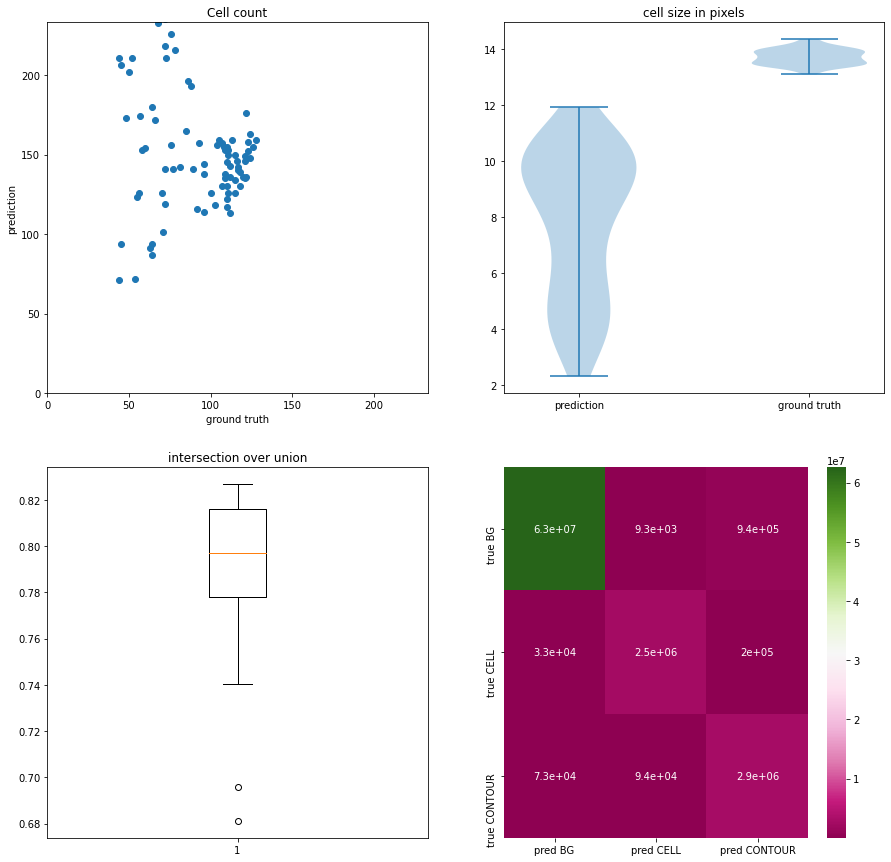

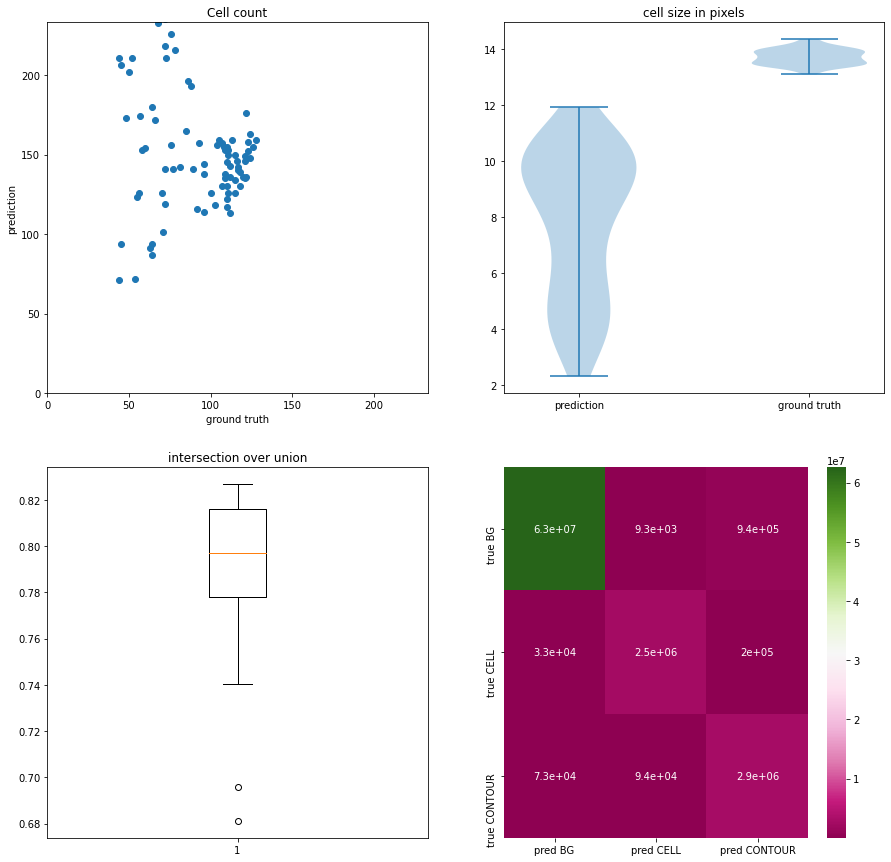

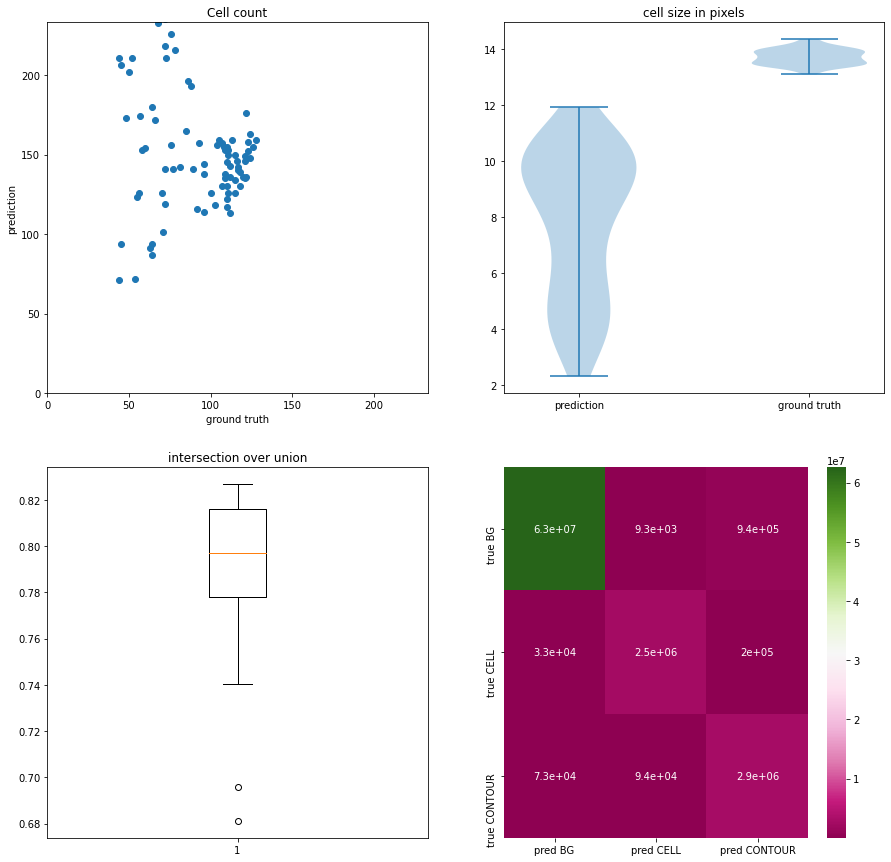

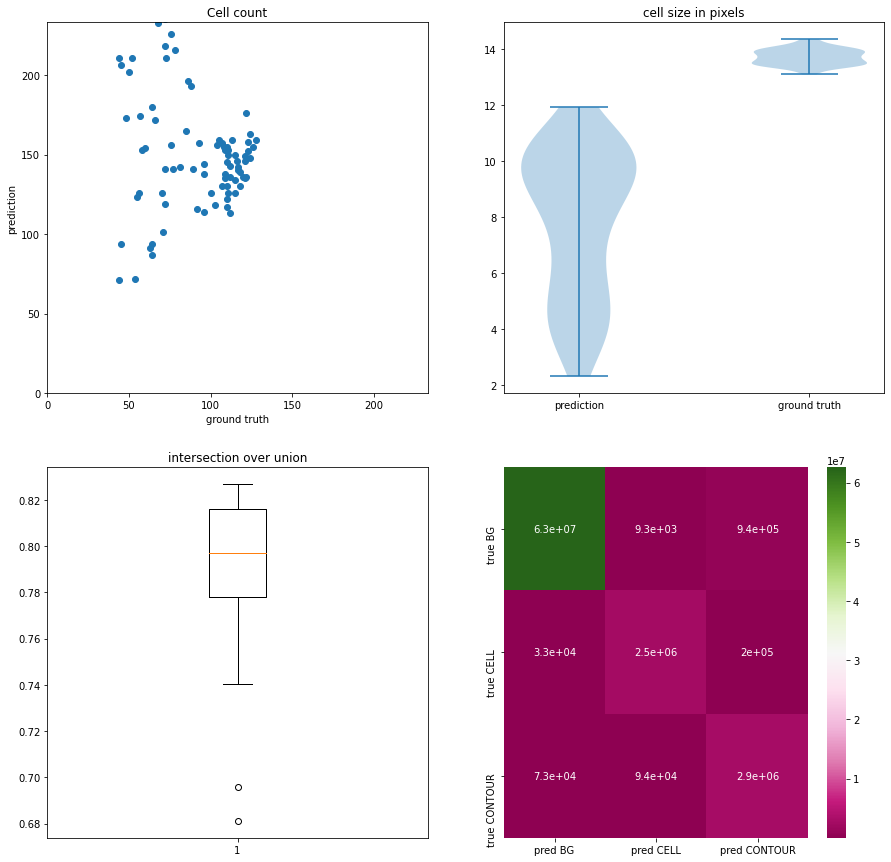

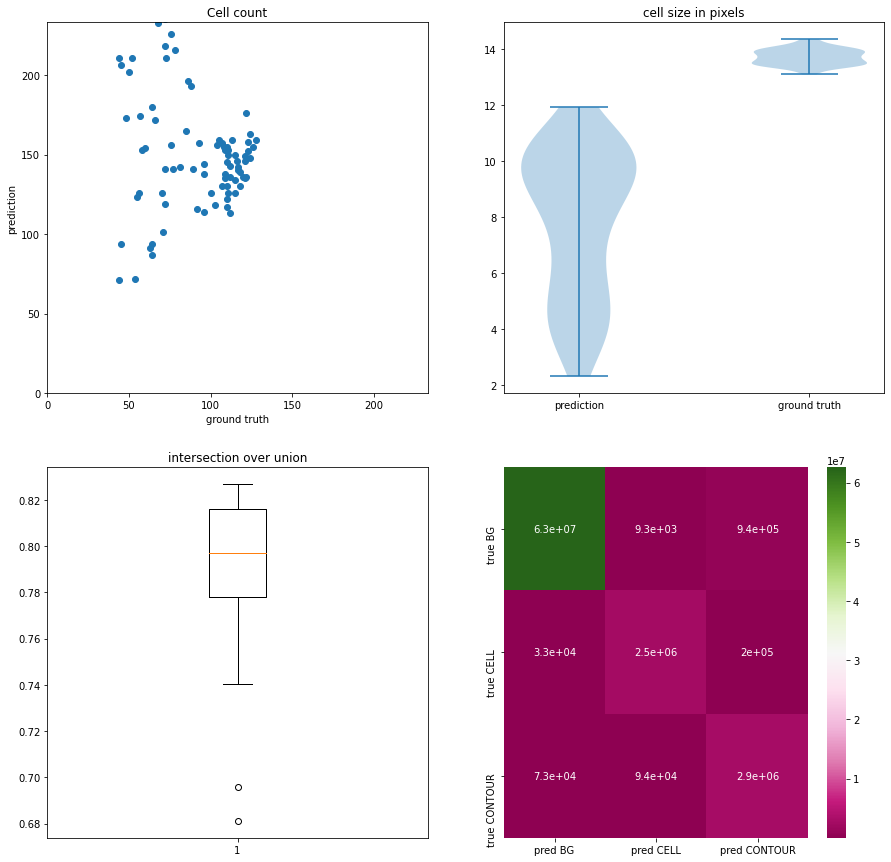

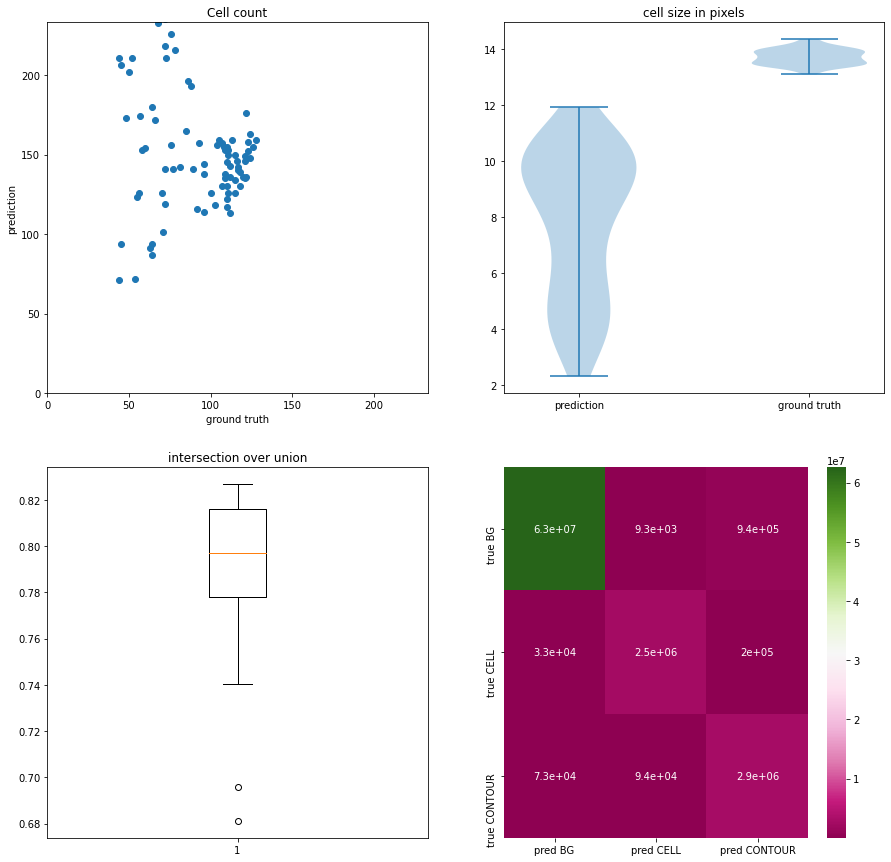

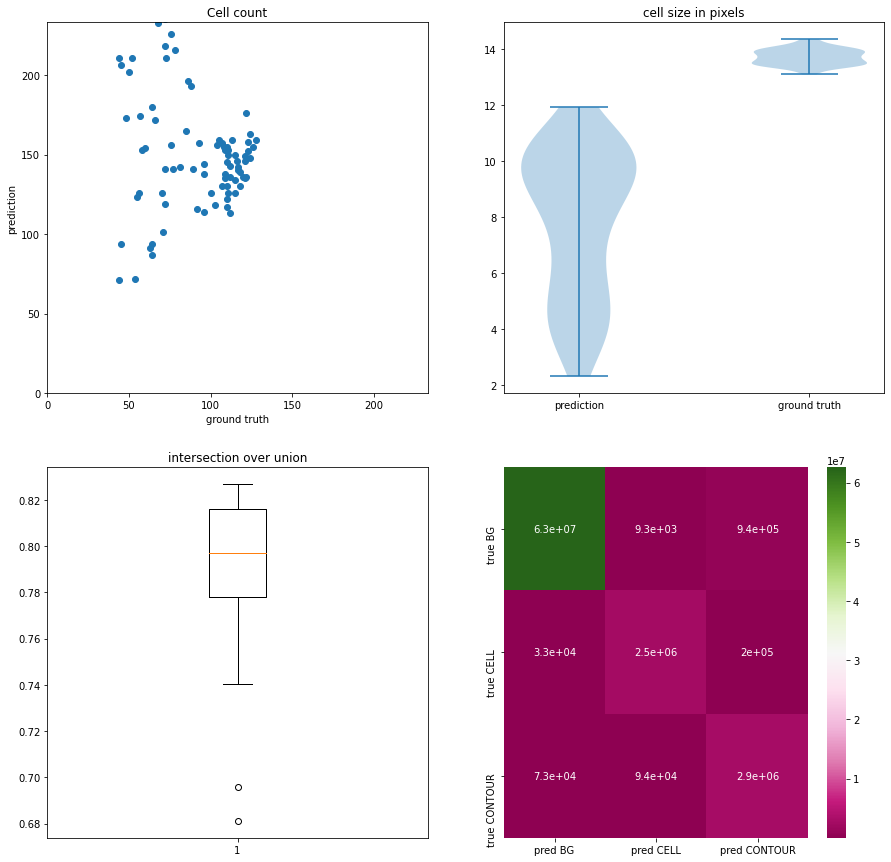

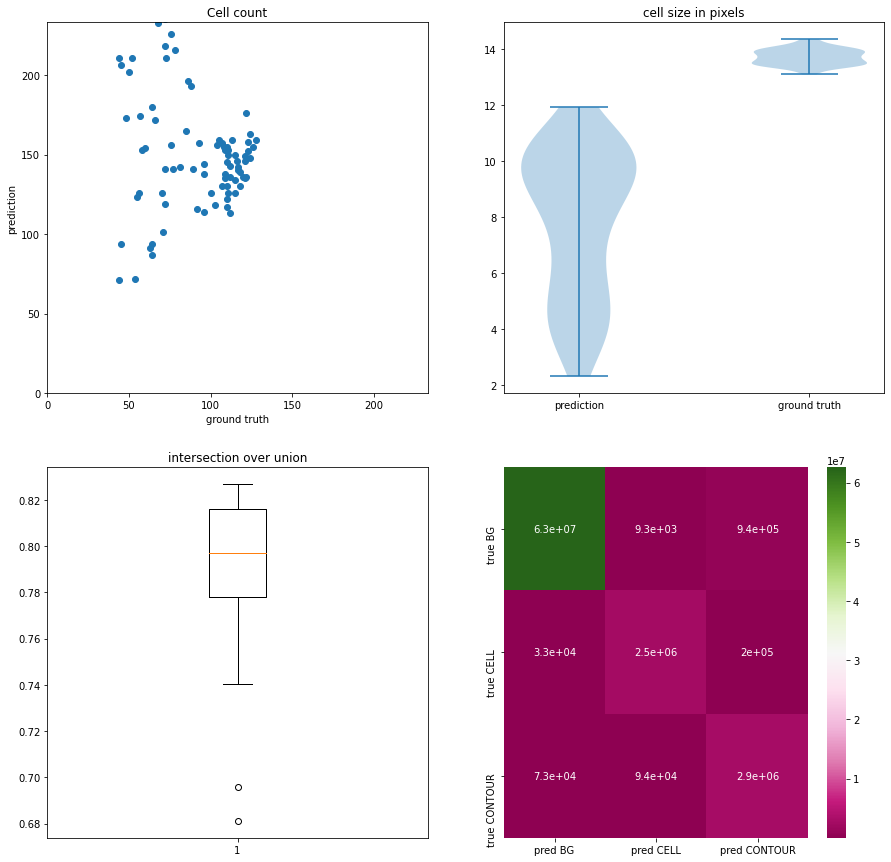

In [756]:
# running assessment

gt_fold_path = "/home/matt/.qu/data/demo_segmentation/masks"

pred_fold_path = "/home/matt/.qu/data/demo_segmentation/preds"
%timeit check_segmentation_predictions(gt_fold_path, pred_fold_path, 1)

In [732]:
a= np.array([0,1,2,0,0])
b = np.array([1,1,0,0,0])


a+b

array([1, 2, 2, 0, 0])